In [1]:
#import primary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')
import scipy
from scipy import stats

In [2]:
train=pd.read_csv('train.loan.csv')
test=pd.read_csv('test.loan1.csv')

In [3]:
train_org=train.copy()
test_org=test.copy()

## Variable Identification

In [4]:
train.shape, test.shape

((614, 13), (367, 12))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
# investigating categorical features
# Loan_ID does not communicate an information, I might drop it later
# it is a binary classification problem, should be checked if target variable is imbalanced or not
train.head().select_dtypes(include=[object])

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y


In [7]:
# investigating numerical features
# it seems Loan_Amount_Term is monthly based
# LoanAmount figures seem to be like loan amount*K (1000) otherwise id does not make sense
# Credit_History is binary, and it's better to convert it to categorical
# Loan_Amount_Term should be converted to categorical data
train.loc[:4, train.dtypes != 'O']

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


In [8]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


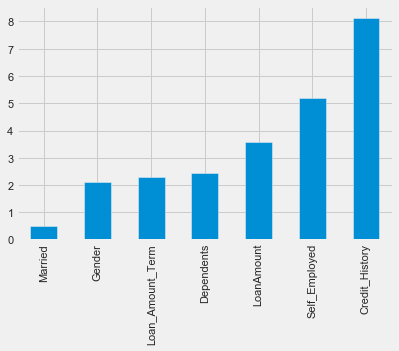

In [9]:
missing=train.isnull().sum()
missing=(missing[missing>0]*100/len(train)).sort_values()
missing.plot(kind='bar')
plt.show()
# Credit_History posesses the most nan-values (roughly 8%), followed by Self_Employed (5%) and LoanAmount (3.5%)

## Univariate Analysis

In [10]:
train['Credit_History']=train['Credit_History'].astype('object')
train['Loan_Amount_Term']=train['Loan_Amount_Term'].astype('object')
target=train['Loan_Status']
train.drop (['Loan_ID'], axis=1, inplace= True)
cat=[f for f in train.columns if train[f].dtype== 'O']
num=[f for f in train.columns if train[f].dtype!= 'O']

In [11]:
print('Categorical Features: {}, \n \nNumerical Features: {}'.format(cat, num))

Categorical Features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'], 
 
Numerical Features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


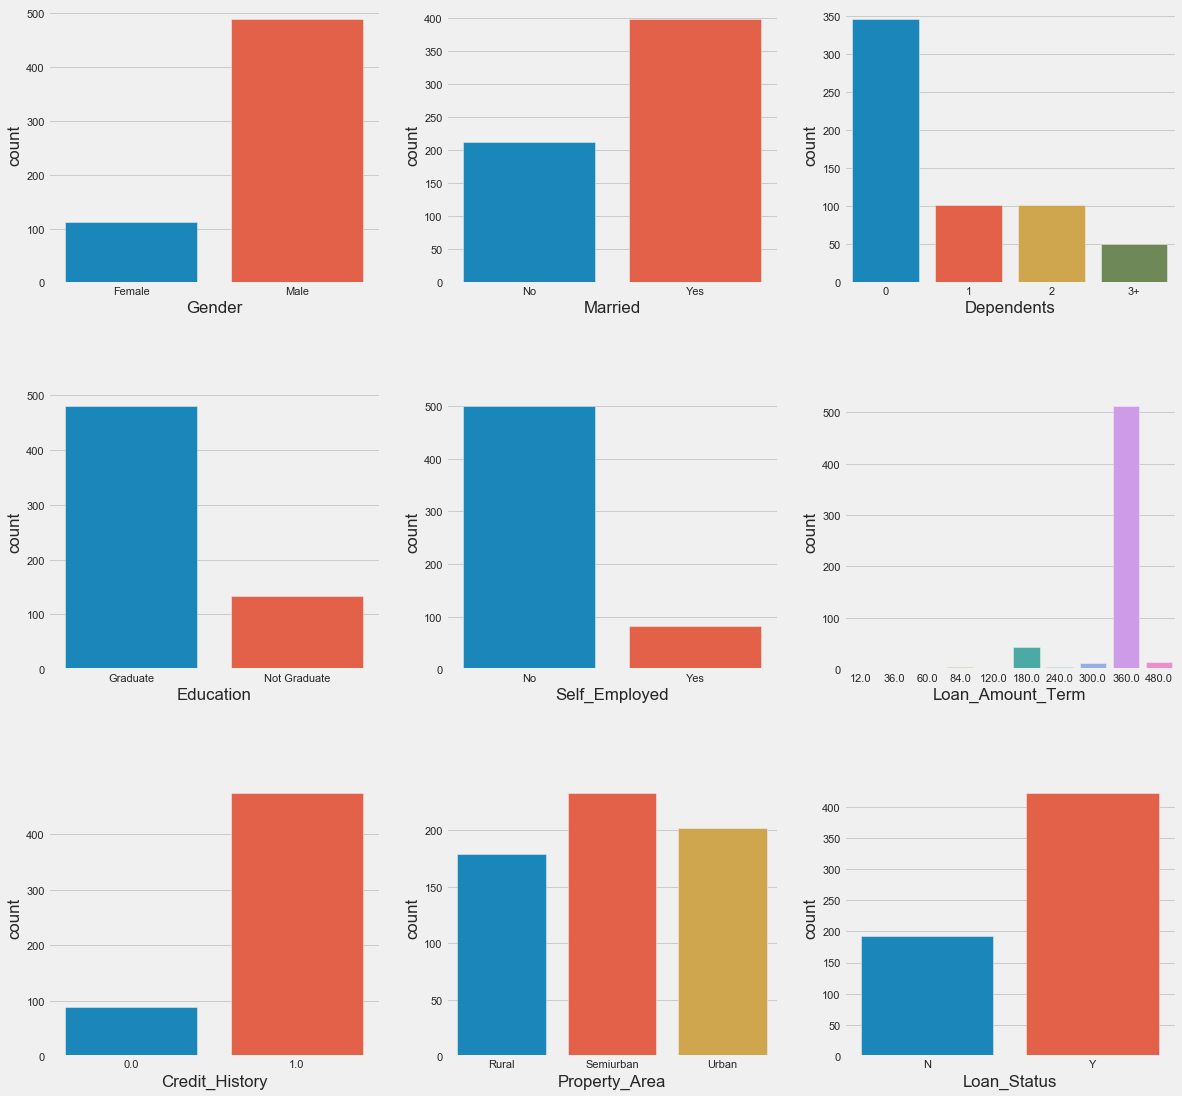

In [12]:
f, axs= plt.subplots(3, 3, figsize=(18, 18), squeeze=False, gridspec_kw={'hspace':0.4, 'wspace':0.2})
axs=axs.flatten()
for i, feature in enumerate(cat):
    ax=axs[i]
    sns.countplot((train[feature]).sort_values(), ax=ax)
    
# most applicatns are male
# most applicants are married
# most applicants does not have any dependents
# most applicants are graduates
# most applicants are employee
# most Loan_Amount_terms are 360 months
# most applicants have credit history
# most applicants live in semi-urban areas followed by urban areas
# most applicants received requested loans, however,it is not an imbalanced problem.

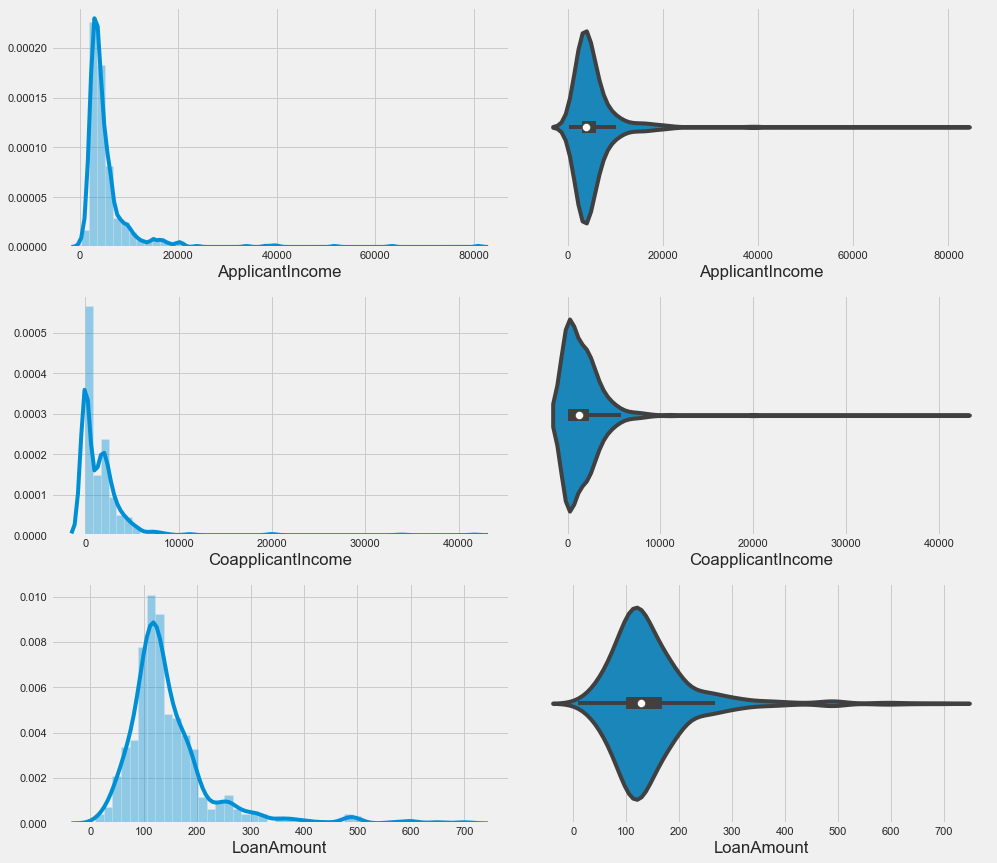

In [13]:
#plt.figure(figsize=(6,4))
f, axs= plt.subplots(3, 2, figsize=(15, 14), squeeze=False, gridspec_kw={'hspace':0.2, 'wspace':0.05})
axs=axs.flatten()
i=0
for feature in num:
    ax1=axs[i]
    ax2=axs[i+1]
    sns.distplot(train[feature], ax= ax1)
    sns.violinplot(train[feature], ax= ax2)
    i=i+2
    
        #plt.figure(1, figsize=(10,6))
        #plt.subplot(121)
        #sns.distplot(train[feature])
        #plt.subplot(122)
        #sns.violinplot(train[feature])
        #plt.show()
# All three plots are positively skewed with the existance of outliers

## Bivariate Analysis

### Categorical vs Target variable (Categorical)

In [14]:
def crosstab(frame, x, y):
    tab=(pd.crosstab(frame[x], y).div(pd.crosstab(frame[x], y).sum(1).astype(float), axis=0))
    return tab

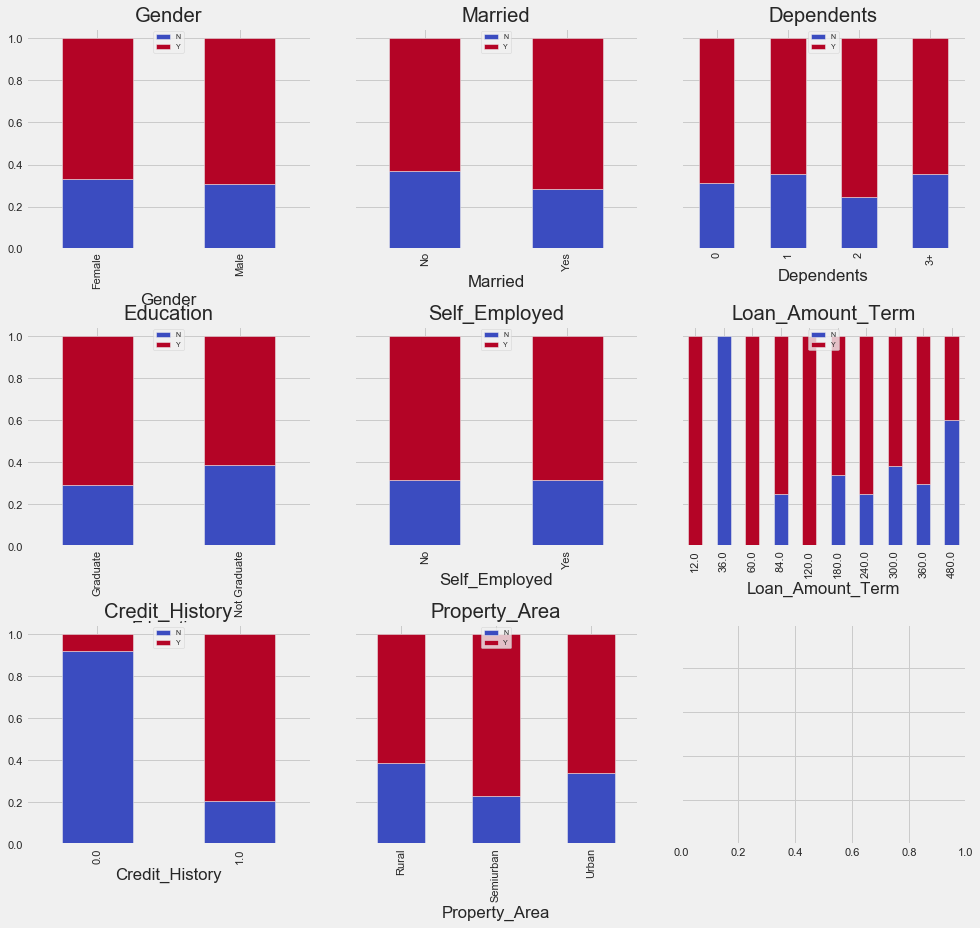

In [15]:
fig,axs= plt.subplots(3, 3, figsize=(15,14), squeeze=False, gridspec_kw={'hspace':0.35, 'wspace':0.15})
#plt.rc('legend', loc='upper left')
axs=axs.flatten() # coverting 2d-array to 1d-array
for i, feature in enumerate(cat):
    if feature!= 'Loan_Status':
        tab=crosstab(train, feature, target)
        #fig=(pd.crosstab(train[feature], target).div(pd.crosstab(train[feature], target).sum(1).astype(float), axis=0))
        ax=axs[i]
        tab.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm', title=feature, sharey=True)
        ax.legend(loc='upper center', prop={'size':7})
        #plt.legend(('Y', 'N'),loc=9, prop={'size':2}, fontsize='x-small')
        #sns.barplot(fig, ax=axs[i])
#it seems having credit history significantly increase the chance of eligibility for a loan. 
#Plus, coming from semiurban area,as well as, being married and graduated might increase the chance of eligibility slightly. 

#### there might be a relation between target variable(Loan Status) and Property Area, Marital status as well as having previous Credit History.

### Numerical vs Target Variable

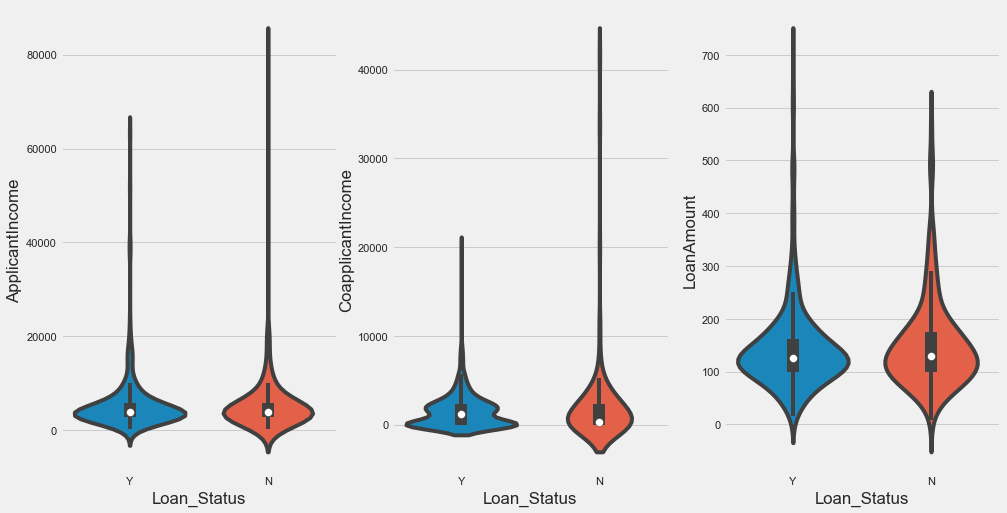

In [16]:
f, axs= plt.subplots(1, 3, figsize=(15,8))
for i, feature in enumerate(num):
    ax=axs[i]
    sns.violinplot(x='Loan_Status', y=feature, data=train, ax=ax)
# no clear insight can be inferred from below plots, one approach to extract more insight is to bin numeric data

In [17]:
data=train.copy()

bins=[0,2500,4000,6000,8100]
group=['Low','Average', 'High', 'Vey high']
data['Applicant_Income_bin']=pd.cut(data.ApplicantIncome, bins, labels=group)

bins=[0,1000,3000,42000]
group=['Low', 'Average', 'High']
data['Coapplicant_Income_bin']=pd.cut(data.CoapplicantIncome, bins, labels=group)

bins=[0,100,200,700]
group=['Low','Average','High']
data['LoanAmount_bin']=pd.cut(data.LoanAmount, bins, labels=group)

data['Total_Income']=data['ApplicantIncome']+ data['CoapplicantIncome']
bins=[0,2500,4000,6000,81000]
group=['Low','Average','High','Very High']
data['Total_Income_bin']=pd.cut(data.Total_Income, bins, labels= group)

bins=[0,240,360,480]
group=['short','mid','long']
data['LoanAmountTerm_bin']=pd.cut(data.Loan_Amount_Term, bins, labels=group)

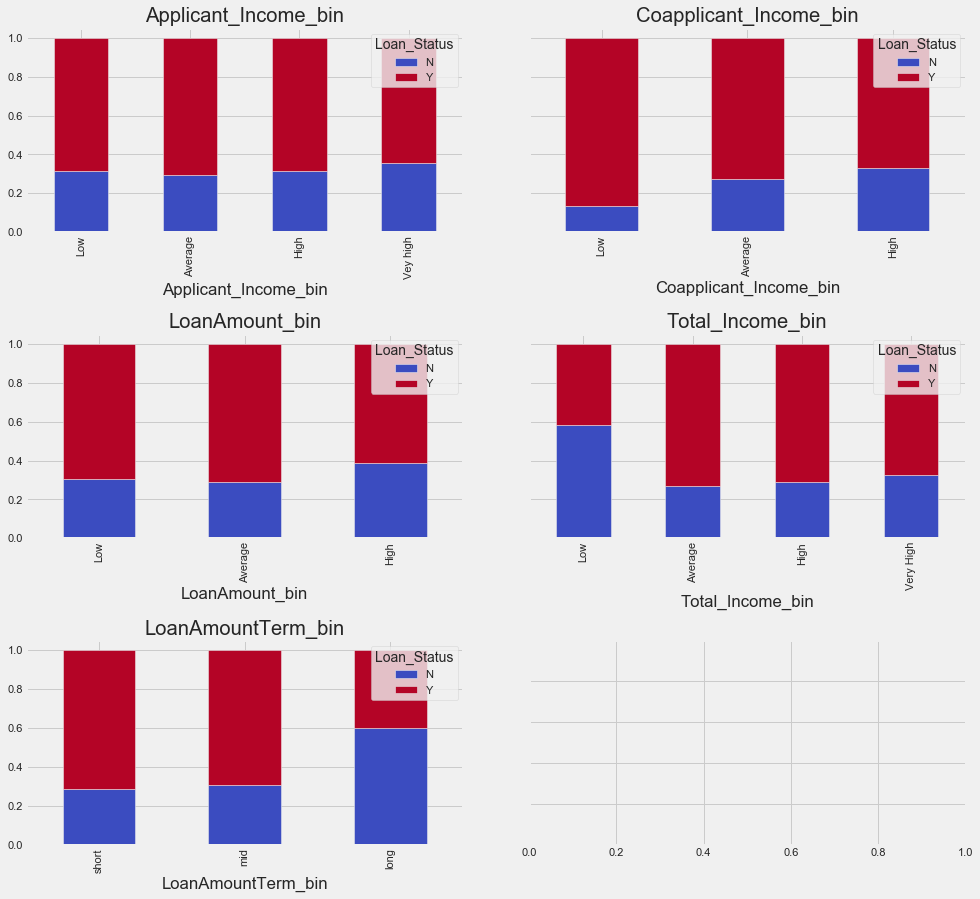

In [18]:
bin=[f for f in data.columns if '_bin' in f]
f, axs= plt.subplots(3, 2, figsize=(15,14), squeeze=False, gridspec_kw={'hspace':0.5, 'wspace':0.15})
axs=axs.flatten()
for i, feature in enumerate(bin):
    ax=axs[i]
    tab=crosstab(data, feature, target)
    tab.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm', title=feature, sharey=True)
# It can be inferred that Applicant income does not affect the chances of loan approval which contradicts our hypothesis
# in which we assumed that if the applicant income is high the chances of loan approval will also be high!

# It shows that if coapplicant’s income is less the chances of loan approval are high. But this does not look right. 
# The possible reason behind this may be that most of the applicants don’t have any coapplicant so the coapplicant income for
# such applicants is 0 and hence the loan approval is not dependent on it. So we can make a new variable in which 
# we will combine the applicant’s and coapplicant’s income to visualize the combined effect of income on loan approval. 

# It can be seen that the proportion of approved loans is higher for Low and Average Loan Amount as compared to that of High Loan
# Amount which supports our hypothesis in which we considered that the chances of loan approval will be high when the loan amount is less.

# We can see that Proportion of loans getting approved for applicants having low Total_Income is very less as compared
# to that of applicants with Average, High and Very High Income.

# below supports our hypothesis regarding lower chance of approval for long-term repay plans.


## Continues vs Continues

In [19]:
data=train.copy()
data['Loan_Amount_Term']= data['Loan_Amount_Term'].astype(float)
data['Credit_History']= data['Credit_History'].astype(float)

#We will change the 3+ in dependents variable to 3 to make it a numerical variable.
data['Dependents'].replace('3+','3',inplace=True)
data['Dependents']= data['Dependents'].astype(float)

#We will also convert the target variable’s categories into 0 and 1 so that we can find its
#correlation with numerical variables.One more reason to do so is few models like 
#logistic regression takes only numeric values as input. We will replace N with 0 and Y with 1.
data['Loan_Status']=np.where(data['Loan_Status']=='Y', 1, 0)
#data.info()

#### Now lets look at the correlation between all the numerical variables. We will use the heat map to visualize the correlation. Heatmaps visualize data through variations in coloring. The variables with darker color means their correlation is more.

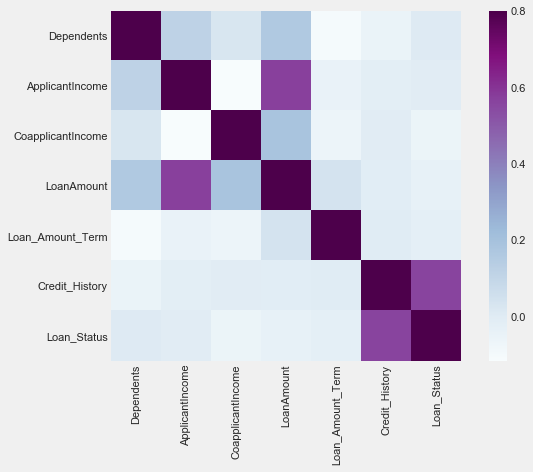

In [20]:
#train['Dependants']=pd.to_numeric(train['Dependents'])
matrix=data.corr()
f,ax=plt.subplots(figsize=(9,6))
sns.heatmap(matrix, vmax=0.8, square=True, cmap='BuPu')
plt.show()

# We see that highly correlated variables are (ApplicantIncome vs LoanAmount) and (Credit_History vs Loan_Status). 
# it seems coaaplicatnt income is slightly negatively correlated with applicant income.

## Missing values Imputation

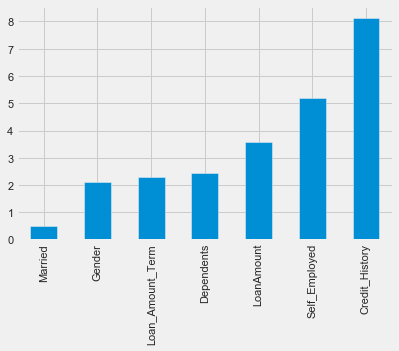

In [21]:
# As we investigated earlier:
missing.plot(kind='bar')
plt.show()
# My assumption is nan-values most probably exist in this dataset due to reluctancy of customers to share this information &
# since there is no meaningful relationship between dependent variables to fill the nan-values based on it I will impute
# nan-values with mode for categorical data and median (due to existance of outliers) for numerical features.
## important note: I'll avoid merging train and test dataset throughout the process of data munging to avoid any data leakage.

In [22]:
cat= set(cat)-set(['Loan_Status'])

In [23]:
from sklearn.impute import SimpleImputer

cat= set(cat)-set(['Loan_Status'])
cat_imp= SimpleImputer(missing_values=np.nan, strategy='most_frequent')
new_cat_train=pd.DataFrame(cat_imp.fit_transform(train[cat]), columns= cat)
new_cat_test=pd.DataFrame(cat_imp.transform(test[cat]), columns= cat)

num_imp= SimpleImputer(missing_values=np.nan, strategy='median')
new_num_train=pd.DataFrame(num_imp.fit_transform(train[num]), columns= num)
new_num_test=pd.DataFrame(num_imp.transform(test[num]), columns= num)

train=pd.concat([new_num_train, new_cat_train], axis=1)
test=pd.concat([new_num_test, new_cat_test], axis=1)

## Feature Engineering

In [24]:
train

,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Education,Self_Employed,Property_Area,Gender,Dependents,Married,Loan_Amount_Term
0,5849.0,0.0,128.0,1,Graduate,No,Urban,Male,0,No,360
1,4583.0,1508.0,128.0,1,Graduate,No,Rural,Male,1,Yes,360
2,3000.0,0.0,66.0,1,Graduate,Yes,Urban,Male,0,Yes,360
3,2583.0,2358.0,120.0,1,Not Graduate,No,Urban,Male,0,Yes,360
4,6000.0,0.0,141.0,1,Graduate,No,Urban,Male,0,No,360
...,...,...,...,...,...,...,...,...,...,...,...
609,2900.0,0.0,71.0,1,Graduate,No,Rural,Female,0,No,360
610,4106.0,0.0,40.0,1,Graduate,No,Rural,Male,3+,Yes,180
611,8072.0,240.0,253.0,1,Graduate,No,Urban,Male,1,Yes,360
612,7583.0,0.0,187.0,1,Graduate,No,Urban,Male,2,Yes,360


In [25]:
#print('1dep:',1/np.e**(1))
#print('2dep: {}'.format(1/np.e**(1)+1/np.e**(2)))
#print('3dep: {}'.format(1/np.e**(1)+1/np.e**(2)+1/np.e**(3)))
#print('4dep: {}'.format(1/np.e**(1)+1/np.e**(2)+1/np.e**(3)+1/np.e**(4)))
#print('5dep: {}'.format(1/np.e**(1)+1/np.e**(2)+1/np.e**(3)+1/np.e**(4)+1/np.e**(5)))

In [26]:
#data=train.copy()
#data['TotalIncome']=data['ApplicantIncome']+data['CoapplicantIncome']
#data.groupby(['Property_Area']).agg({'TotalIncome':np.median}).reset_index()


In [27]:
# Lets create a new feature, TotalIncome, as we've seen it better supports our hypothesis
def feature_creator(frame):
# Lets create a new feature, TotalIncome, as we've seen it better supports our hypothesis
    frame['TotalIncome']=frame['ApplicantIncome']+frame['CoapplicantIncome']

# It is good to know if the applicant income is the only stream of income or not
    frame['IncomeStream']=np.where(frame['CoapplicantIncome']==0, 'Single', 'Multi')

# It is better to have an understanding regarding the amount of installment, the applicant have to pay per month
    frame['MonthlyInstallment']=frame['LoanAmount']*1000/frame['Loan_Amount_Term']
    frame['MonthlyInstallment']=frame['MonthlyInstallment'].astype(float)

# Also it might be useful to have a ratio of LoanAmount/TotalIncome
    frame['Loan/IncomePercentage']=frame['MonthlyInstallment']*100/frame['TotalIncome']
    frame['Loan/IncomePercentage']=frame['Loan/IncomePercentage'].astype(float)
    


# Number of dependents affect the financial strength of a family to repay the installments, it's good to consider a coefficient
# but first we need to replace '3+' with '3' in dependents feature and create a new variable 'FragilityCoefficient'.
# I do not have adequate financial domain knowladege, however, my assumption is this coefficient follows natural logarithic
# rate, hence I'll apply below formula to calculate fragility coefficient:
# FFC= 1-(sum(1/e^n)), where n ranges from 1 to maximum number of dependents
# Also to calculate financial margin I will apply below formula:
# FM= TotalIncome*(FFC)
    frame['Dependents'].replace('3+', '3', inplace=True)
    frame['Dependents']= frame['Dependents'].astype(int)
    frame.loc[(frame['CoapplicantIncome']==0) & (frame['Married']=='Yes' ), ['Dependents']]=frame.loc[
    (frame['CoapplicantIncome']==0) & (frame['Married']=='Yes' ), ['Dependents']].apply(lambda row: row+1)
    frame['HouseholdSize']=frame['Dependents'].apply(lambda row: row+1)
    def FFC(x):
        if x==0:
            return 1-int(0)
        elif x==1:
            return 1-float(0.368)
        elif x==2:
            return 1-float(0.503)
        elif x==3:
            return 1-float(0.553)
        elif x==4:
            return 1-float(0.571)
        else:
            return 1-float(0.578)
            
    frame['FFC']=frame['HouseholdSize'].apply(lambda row: FFC(row))
    frame['FinancialMargin']=frame['TotalIncome']*frame['FFC']
# we can decide financial capability of each household by comparing FinancialMargine and Monthly Installment
    frame['CapabilityRate']=frame['FinancialMargin']/frame['MonthlyInstallment']
    frame['CapabilityRate']=frame['CapabilityRate'].astype(float)
    frame['FinancialCapability']= frame['CapabilityRate'].apply(lambda x: 'Capable' if x>5 else 'Not Capable')
                                            
# Also it is good to know if the applicant is above median income of its property or not
    frame['MedianIncome']=np.zeros(shape=(len(frame)))
    frame.loc[(frame['Property_Area']=='Rural') & (frame['TotalIncome']<float(5704.0)), ['MedianIncome']]='Below Median'
    frame.loc[(frame['Property_Area']=='Rural') & (frame['TotalIncome']>=float(5704.0)), ['MedianIncome']]='Above Median'
    frame.loc[(frame['Property_Area']=='Semiurban') & (frame['TotalIncome']<float(5191.0)), ['MedianIncome']]='Below Median'
    frame.loc[(frame['Property_Area']=='Semiurban') & (frame['TotalIncome']>=float(5191.0)), ['MedianIncome']]='Above Median'
    frame.loc[((frame['Property_Area']=='Urban') & (frame['TotalIncome']<float(5258.5))), ['MedianIncome']]='Below Median'
    frame.loc[((frame['Property_Area']=='Urban') & (frame['TotalIncome']>=float(5258.5))), ['MedianIncome']]='Above Median'



In [28]:
feature_creator(train)
feature_creator(test)

## Outlier Treatment

#### Loan Amount: Due to it's outliers bulk of the data in the loan amount is at the left and the right tail is longer. This is called right skewness. One way to remove the skewness is by doing the log transformation. As we take the log transformation, it does not affect the smaller values much, but reduces the larger values. So, we get a distribution similar to normal distribution. I'll transform the other two numerical features as well to penalize outliers at the right tail.

In [29]:
data=train.copy()
data[num]=np.log1p(data[num])
#train[num]=np.log1p(train[num])
#test[num]=np.log1p(test[num])
#train['CoapplicantIncome']=np.exp(train['CoapplicantIncome'])
#test['CoapplicantIncome']=np.exp(test['CoapplicantIncome'])

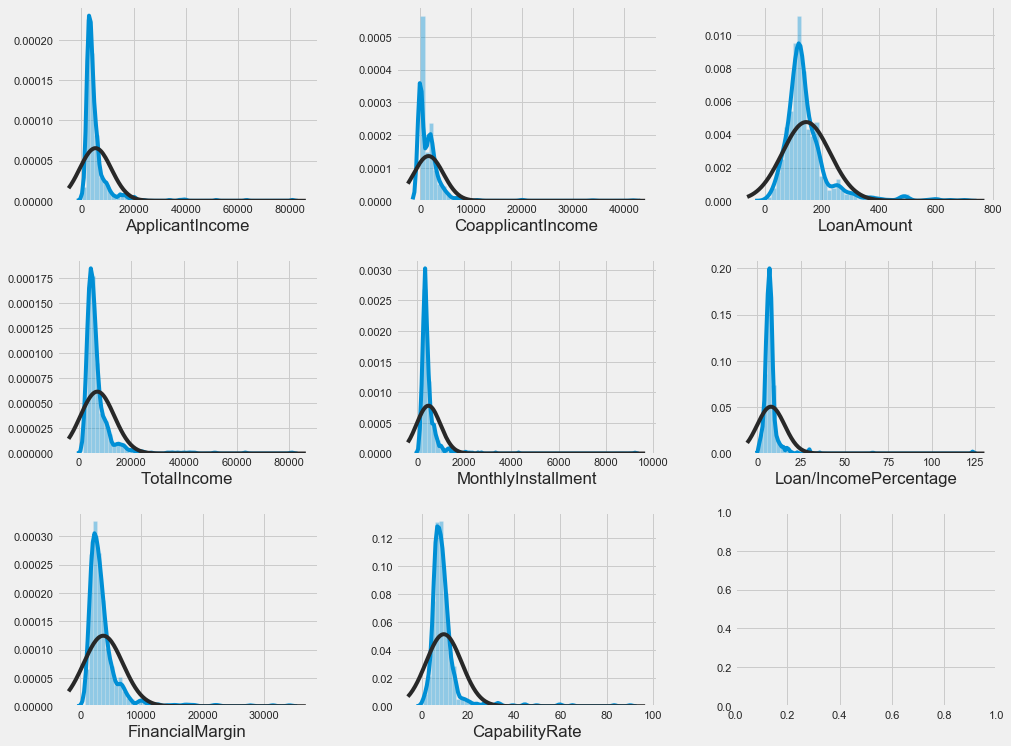

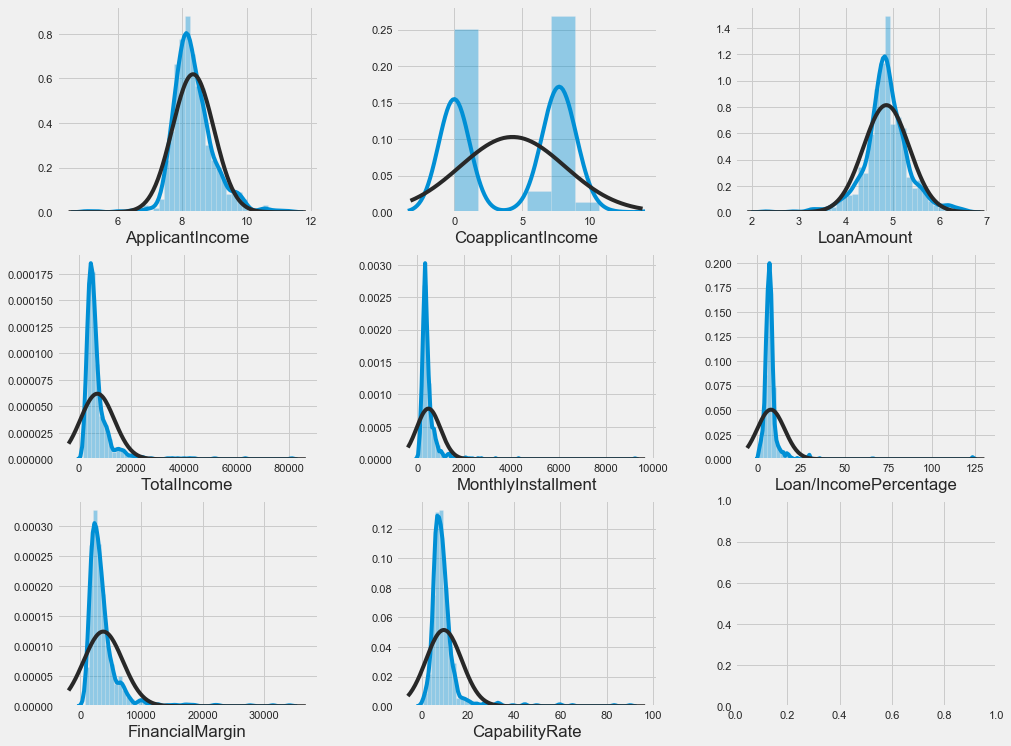

In [30]:
# Dependents, HouseholdSize & FFC are descrete numerical variables, hence it's better to exclude those while log transformation
def dtype_convertor(frame, dtype):
    frame[feature]=frame[feature].astype(dtype)
for feature in ['Dependents', 'HouseholdSize', 'FFC']:
    dtype_convertor(train, object)
    dtype_convertor(test, object)
#train['Dependents', 'HouseholdSize', 'FFC']=train['Dependents', 'HouseholdSize', 'FFC'].astype('O')

num=[f for f in train.columns if train[f].dtype!='object']

f, axs= plt.subplots(3,3, figsize=(15,12), gridspec_kw={'wspace':0.3, 'hspace':0.3})
axs=axs.flatten()
for i,feature in enumerate(num):
    ax=axs[i]
    sns.distplot(train[feature], ax=ax, fit=stats.norm)
plt.show()
f, axs= plt.subplots(3,3, figsize=(15, 12), gridspec_kw={'wspace':0.3})
axs=axs.flatten()
for i,feature in enumerate(num):
    ax=axs[i]
    sns.distplot(data[feature], ax=ax, fit=stats.norm)


#### Now the distribution looks much closer to normal and effect of extreme values has been significantly subsided.

## Preprocessing & Feature Transformation

### Categorical Variables

In [31]:
#label encoding

cat=[f for f in train.columns if train[f].dtype=='object']
lab_lst=[f for f in cat if len(train[f].unique())>4]

def lab_encode(frame, feature):    
    keys=sorted(frame[feature].unique().tolist())
    values=[]
    for i, key in enumerate(keys):
        values.append(i)
    mapping=dict(zip(keys, values))
    frame[feature+'_lab']=frame[feature].map(mapping)

for feature in lab_lst:
    lab_encode(train, feature)
    lab_encode(test, feature)

In [32]:
# one hot encoding

dummy_cols=[f for f in cat if f not in lab_lst]

ohe_train=pd.get_dummies(train[dummy_cols])
train.drop(dummy_cols, axis=1, inplace=True)
train=pd.concat([train, ohe_train], axis=1)    

ohe_test=pd.get_dummies(test[dummy_cols])
test.drop(dummy_cols, axis=1, inplace=True)
test=pd.concat([test, ohe_test], axis=1) 

train.shape, test.shape
    

((614, 35), (367, 35))

In [33]:
#ohe_target=pd.get_dummies(target)
#target=ohe_target
#target.drop(['N'], axis=1, inplace=True)
#target

### Numerical Variables

In [34]:
# Normalizing numerical variables

features=train.columns
ohe_features=ohe_train.columns
trans_lst=set(features)-set(dummy_cols)-set(ohe_features)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
train_num=train[trans_lst].values
test_num=test[trans_lst].values
train_num_norm=pd.DataFrame(scaler.fit_transform(train_num), columns=trans_lst)
test_num_norm=pd.DataFrame(scaler.transform(test_num), columns=trans_lst)
train.drop(trans_lst, axis=1, inplace=True)
test.drop(trans_lst, axis=1, inplace=True)
new_train=pd.concat([train_num_norm, train], axis=1)
new_test=pd.concat([test_num_norm, test], axis=1)

new_train.shape, new_test.shape

((614, 35), (367, 35))

In [35]:
train=new_train
test=new_test
train_cols=train.columns
test_cols=test.columns

## Feature Selection

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

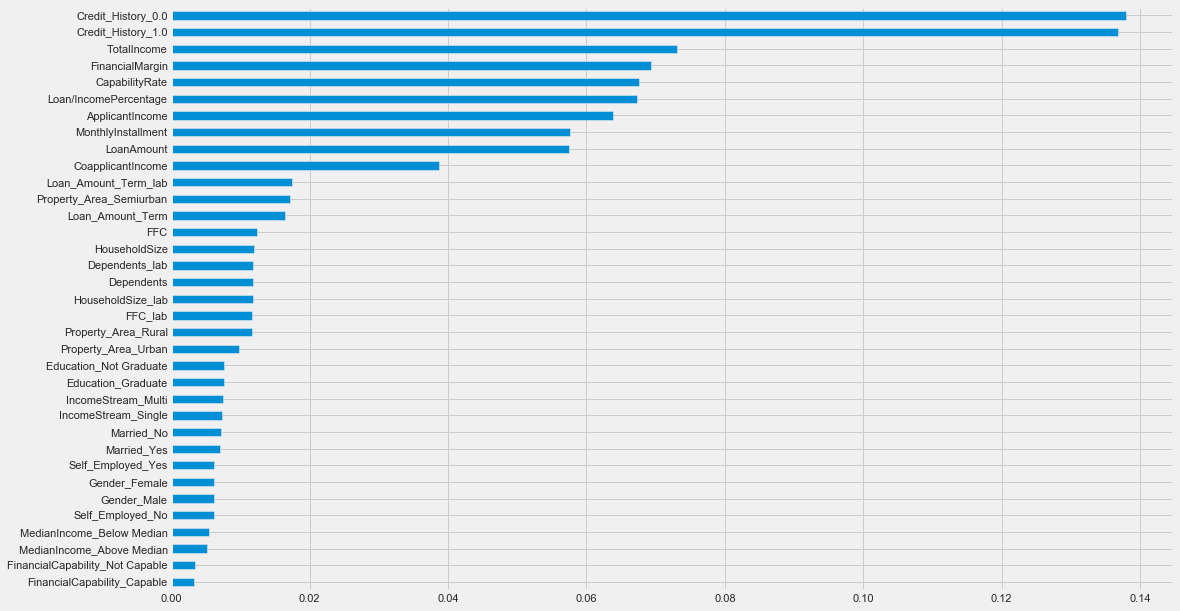

In [37]:
X=train
y=target

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.4, random_state=1)

rf=RandomForestClassifier(n_estimators=5000, random_state=1)

rf.fit(X_train, y_train)

importances=pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(16, 10))
plt.show()

In [38]:
# I tried a list of numbers for threshold, however 0.2 produce the best accuracy score
sfm=SelectFromModel(rf, threshold=0.02)
sfm.fit(X_train, y_train)


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=5000, n_jobs=None,
                                                 oob_score=False

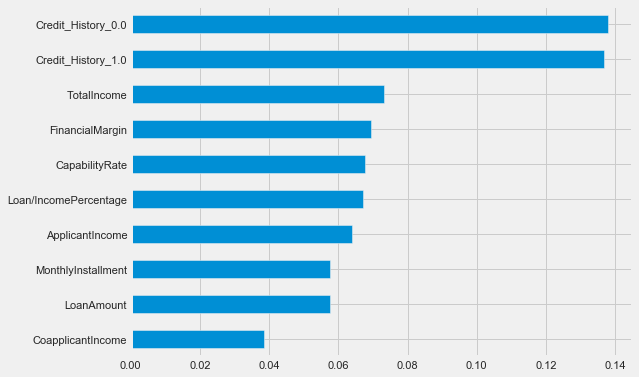

In [39]:
imp_features=[]
for feature in sfm.get_support(indices=True):
    imp_features.append(feature)

importances[imp_features].sort_values().plot(kind='barh', figsize=(8, 6))
plt.show()

In [40]:
X_important_train=sfm.transform(X_train)
X_important_test=sfm.transform(X_test)

rf_important=RandomForestClassifier(n_estimators=5000, random_state=1)
rf_important.fit(X_important_train, y_train)

y_pred=rf.predict(X_test)
y_important_pred=rf_important.predict(X_important_test)

print('Accuracy score of original dataset{} \n \nAccuracy score of feature-selected dataset{}'
      .format(accuracy_score(y_test, y_pred), accuracy_score(y_test, y_important_pred)))

Accuracy score of original dataset0.7642276422764228 
 
Accuracy score of feature-selected dataset0.7804878048780488


In [41]:
sfm.fit(X, y)
X=sfm.transform(X)
test=sfm.transform(test)
X=pd.DataFrame(X, columns=train_cols[imp_features])
test=pd.DataFrame(test, columns=train_cols[imp_features])

### By reducing number of features from 35 to 10, I improved Accuracy score from 0.764 to 0.785

## Now we can move on to the next stage, which is building a predictive model

# Model Building

### to Build a model, I'll try different algorithms and evaluate their performances by Accuracy, Finally I'll apply a stacking method which combines all the algorithms to see if I get a better result


In [51]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
#!pip install lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std

from matplotlib import pyplot

In [55]:
# first I define a stacking function
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('nb', GaussianNB()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('ada', AdaBoostClassifier()))
    level0.append(('lgb', LGBMClassifier()))
    level0.append(('xgb', XGBClassifier()))
    level0.append(('rf', RandomForestClassifier()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [56]:
# next I define a function to evaluate different models
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [57]:
# here I define function to create a dictionary of desired algorithms
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['nb'] = GaussianNB()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['ada'] = AdaBoostClassifier()
    models['lgb'] = LGBMClassifier()
    models['xgb']= XGBClassifier()
    models['rf']= RandomForestClassifier()
    models['stacking'] = get_stacking()
    return models

>lr 0.809 (0.027)
>nb 0.797 (0.037)
>knn 0.802 (0.038)
>cart 0.709 (0.056)
>svm 0.806 (0.029)
>ada 0.790 (0.039)
>lgb 0.771 (0.045)
>xgb 0.760 (0.049)
>rf 0.797 (0.043)
>stacking 0.804 (0.032)


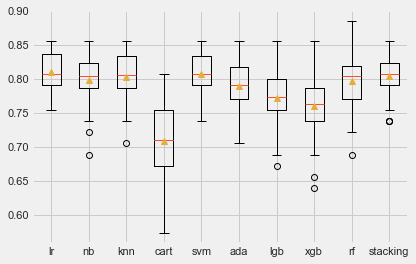

In [58]:
# creating a dictionary of models
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## It seems Logistic Regression Provides the best results.

In [84]:
from sklearn.model_selection import StratifiedKFold
mean_score=[]
i=1 
kf= StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = y.loc[train_index],y.loc[test_index]         
    model = LogisticRegression(random_state=1)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)
    mean_score.append(score)
    i+=1 

print('\nmean of scores:', np.mean(mean_score))
final_prediction = model.predict(test) 
pred=model.predict_proba(xvl)[:,1]


1 of kfold 5
accuracy_score 0.8130081300813008

2 of kfold 5
accuracy_score 0.8373983739837398

3 of kfold 5
accuracy_score 0.7967479674796748

4 of kfold 5
accuracy_score 0.8048780487804879

5 of kfold 5
accuracy_score 0.7950819672131147

mean of scores: 0.8094228975076636


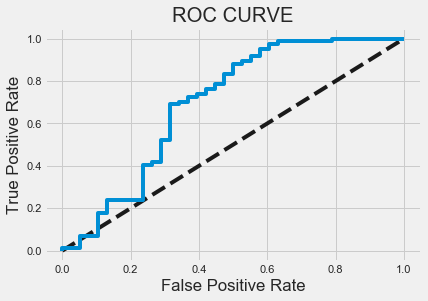

In [88]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(yvl,pred, pos_label='Y')
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.show()

In [96]:
submission=pd.read_csv('sample_submission.csv')
submission.head()

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N
3,LP001035,N
4,LP001051,N


In [97]:
submission=submission.drop(['Loan_Status'], axis=1)
submission['Loan_Status']=final_prediction
submission.to_csv('submission.csv', index=False)